## Subquestion 3 pipeline
TO SOLVE: Are there noticeable patterns of sentiment oscillation in the paths chosen by players? For instance, do players often navigate through contrasting sentiments to reach their target, such as starting from an article with a negative tone like “Hell” to reach a positive one like “Paradise”?

### Loading data
loading the paths and sentiment scores for each article
Assumptions:
- graph is undirected, because the user can always return back to the previous article via the back button.
- User paths can have circle, the back button in path is equivalent as the previous previous article.
- The sentiment score is generated by Roberta model and it's a 3 dimensional(positive neutral negative) vector, the sum of the 3 dimensions is 1.

In [58]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [59]:
def replace_lt_with_previous(article_path):
    path_elements = article_path.split(';')
    for i, element in enumerate(path_elements):
        if element == '<' and i > 1:
            path_elements[i] = path_elements[i-2]
    return ';'.join(path_elements)

In [60]:
file_path = '../data/paths_finished.tsv'
df_finished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
df_finished.columns = cols
df_finished['target'] = df_finished['path'].apply(lambda x: x.split(';')[-1])
df_finished['type'] = 'finished'
file_path = '../data/paths_unfinished.tsv'
df_unfinished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']
df_unfinished.columns = cols
df = pd.concat([df_finished, df_unfinished], axis=0)
df['start'] = df['path'].apply(lambda x: x.split(';')[0])
df['path_length'] = df['path'].apply(lambda x: len(x.split(';')))
df['path'] = df['path'].apply(replace_lt_with_previous)
# dump to csv
df[['durationInSec', 'path', 'target', 'type', 'start', 'path_length']].to_csv('../data/paths.tsv', sep='\t', index=False)

In [61]:
articles = pd.read_csv('../data/articles.tsv', sep='\t', header=None)
file_path = '../data/links.tsv'
df_links = pd.read_csv(file_path, sep='\t', header=None)
articles.columns = ['article']
degree_out = df_links.groupby(0).count().reset_index()
degree_out.columns = ['article', 'degree_out']
degree_in = df_links.groupby(1).count().reset_index()
degree_in.columns = ['article', 'degree_in']
articles = articles.merge(degree_out, on='article', how='left').fillna(0).merge(degree_in, on='article', how='left').fillna(0)
articles['degree'] = articles['degree_out'] + articles['degree_in']
article_freq = pd.DataFrame(df['path'].apply(lambda x: x.split(';')).explode().value_counts()).reset_index()
articles_cnt = pd.merge( articles, article_freq, left_on='article', right_on='path', how='left').fillna(0)
articles_cnt.head()

,article,degree_out,degree_in,degree,path,count
0,# The list of all articles.,0.0,0.0,0.0,0,0.0
1,"# Article names are URL-encoded; e.g., in Java...",0.0,0.0,0.0,0,0.0
2,# FORMAT: article,0.0,0.0,0.0,0,0.0
3,#,0.0,0.0,0.0,0,0.0
4,"# When publishing on this data set, please cite:",0.0,0.0,0.0,0,0.0


In [62]:
with open('tmp/sentiments.pickle', 'rb') as handle:
    sentiments = pickle.load(handle)

articles_cnt['sentiment_pos'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][2] if x+".txt" in sentiments else 0)
articles_cnt['sentiment_neu'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][1] if x+".txt" in sentiments else 0)
articles_cnt['sentiment_neg'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][0] if x+".txt" in sentiments else 0)
articles_cnt[['article','degree','sentiment_pos', 'sentiment_neu', 'sentiment_neg']].to_csv('../data/articles_sentiments.tsv', sep='\t', index=False)
articles_cnt
# output the df to csv
# articles_cnt.to_csv('../data/articles.tsv', sep='\t', index=False)

,article,degree_out,degree_in,degree,path,count,sentiment_pos,sentiment_neu,sentiment_neg
0,# The list of all articles.,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
1,"# Article names are URL-encoded; e.g., in Java...",0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
2,# FORMAT: article,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
3,#,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
4,"# When publishing on this data set, please cite:",0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
4610,Zionism,74.0,25.0,99.0,Zionism,28.0,0.072466,0.663531,0.264004
4611,Zirconium,42.0,15.0,57.0,Zirconium,34.0,0.097269,0.781787,0.120944
4612,Zoroaster,28.0,9.0,37.0,Zoroaster,22.0,0.084953,0.786462,0.128585
4613,Zuid-Gelders,5.0,5.0,10.0,Zuid-Gelders,10.0,0.069110,0.797628,0.133262


### Sentiment visualization
It gives visualizations of the sentiment scores of the articles in the graph. and conduct some first glance observations.

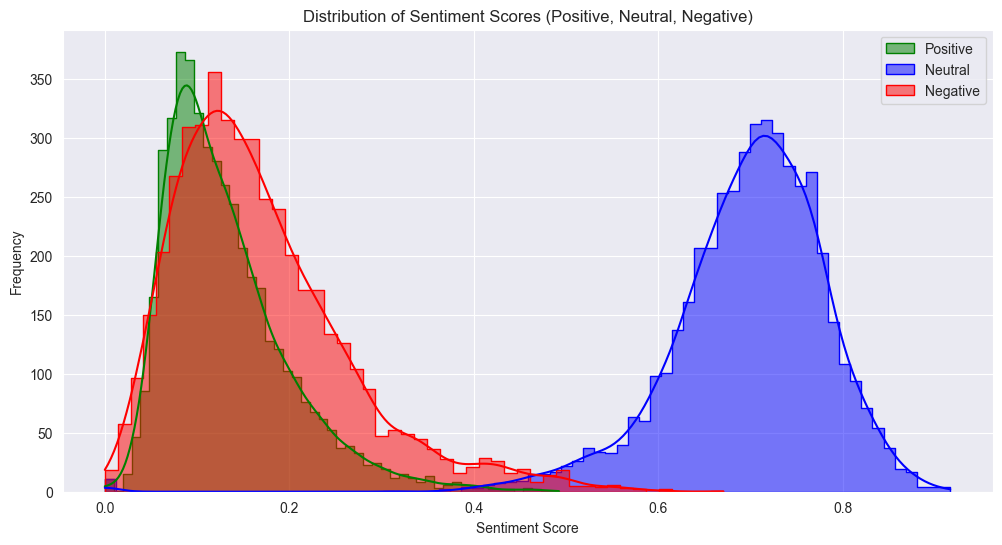

In [63]:
plt.figure(figsize=(12, 6))
sns.histplot(data=articles_cnt, x="sentiment_pos", color="green", label="Positive", kde=True, element="step")
sns.histplot(data=articles_cnt, x="sentiment_neu", color="blue", label="Neutral", kde=True, element="step")
sns.histplot(data=articles_cnt, x="sentiment_neg", color="red", label="Negative", kde=True, element="step")
plt.title("Distribution of Sentiment Scores (Positive, Neutral, Negative)")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Firstly visualize the 3 type score saparately, we can see that the majority of the scores tend to be neutral, with fewer instances of strong positive or negative sentiments.

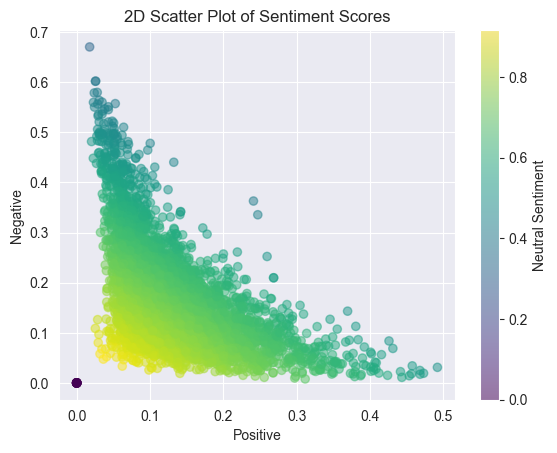

neutral article percentage: 


,article,degree_out,degree_in,degree,path,count,sentiment_pos,sentiment_neu,sentiment_neg
2158,Iraq_War,57.0,22.0,79.0,Iraq_War,77.0,0.024308,0.425385,0.550307


In [64]:
plt.scatter(articles_cnt['sentiment_pos'], articles_cnt['sentiment_neg'], c=articles_cnt['sentiment_neu'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Neutral Sentiment')
plt.title("2D Scatter Plot of Sentiment Scores")
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.grid(True)
plt.show()
print("neutral article percentage: ")
articles_cnt[(articles_cnt['sentiment_pos'] < 0.3) & (articles_cnt['sentiment_neg'] < 0.3)].shape[0] / articles_cnt.shape[0]
articles_cnt[articles_cnt['article'] == 'Iraq_War']

then we draw the distribution per article, neutral sentiment is article still the majority.(>88%)

### Sentiment Oscillation analysis
This block will analyze the sentiment oscillation pattern for edges in the network, it will be used to define the threshold of "oscillation" for the edges.
- sum of the absolute difference of the positive/negative sentiment scores between two articles in the edge is used to define the oscillation.
- the threshold is defined as the 90% quantile of the oscillation score.

In [65]:
link_sentiments = df_links.merge(articles_cnt[['article', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']], left_on=0, right_on='article', how='left').drop(columns=['article']).merge(articles_cnt[['article', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']], left_on=1, right_on='article', how='left',suffixes=('_0', '_1')).drop(columns=['article'])
link_sentiments["oscillation"] = abs(link_sentiments['sentiment_pos_0'] - link_sentiments['sentiment_pos_1']) + abs(link_sentiments['sentiment_neg_0'] - link_sentiments['sentiment_neg_1'])

threshold_oscillation = link_sentiments['oscillation'].quantile(0.9)
print("threshold of oscillation: ", threshold_oscillation)
# save the link_sentiments to csv
# link_sentiments.to_csv('../data/link_sentiments.tsv', sep='\t', index=False)

threshold of oscillation:  0.2802105601443185


we get the threshold of oscillation as **0.28**, random select 10 links with oscillation score higher than the threshold, and 10 links lower to see if the threshold is reasonable.

In [66]:
link_sentiments[link_sentiments['oscillation'] > 0.28].sample(10)

,0,1,sentiment_pos_0,sentiment_neu_0,sentiment_neg_0,sentiment_pos_1,sentiment_neu_1,sentiment_neg_1,oscillation
9603,Aruba,Caribbean_Sea,0.373491,0.607515,0.018993,0.103164,0.664721,0.232115,0.483449
11151,Autism,United_Kingdom,0.085880,0.504089,0.410032,0.207140,0.696025,0.096835,0.434458
112678,United_States_Bill_of_Rights,New_York_City,0.071050,0.719919,0.209031,0.266598,0.656196,0.077206,0.327372
27899,Criticism_of_the_War_on_Terrorism,Mass_media,0.028658,0.414901,0.556440,0.186257,0.691437,0.122306,0.591732
104719,Syria,Drought,0.100135,0.709261,0.190604,0.055313,0.453375,0.491312,0.345531
106445,The_Blitz,Southampton,0.063412,0.567377,0.369210,0.151599,0.742681,0.105720,0.351678
30048,Democratic_Republic_of_the_Congo,Argentina,0.076209,0.701949,0.221842,0.285276,0.630039,0.084685,0.346224
85550,Physical_paradox,Special_relativity,0.077776,0.579745,0.342479,0.163776,0.723802,0.112422,0.316058
66751,Liverpool,Pound_sterling,0.316523,0.615254,0.068223,0.088636,0.723720,0.187644,0.347309
66790,Llandudno,Liberal_Democrats,0.342983,0.624164,0.032853,0.118871,0.665679,0.215449,0.406709


In [67]:
link_sentiments[link_sentiments['oscillation'] < 0.28].sample(10)

,0,1,sentiment_pos_0,sentiment_neu_0,sentiment_neg_0,sentiment_pos_1,sentiment_neu_1,sentiment_neg_1,oscillation
24096,Church_of_England,Augustine_of_Hippo,0.097084,0.778686,0.124230,0.099935,0.768632,0.131434,0.010054
107823,Thomas_Aquinas,Trinity,0.179043,0.744195,0.076762,0.108179,0.775433,0.116388,0.110490
95699,Sassanid_Empire,Roman_Empire,0.110844,0.769900,0.119257,0.065348,0.678970,0.255682,0.181921
16764,Book_of_Common_Prayer,James_I_of_England,0.082043,0.741638,0.176318,0.085613,0.683216,0.231171,0.058422
109898,Tree,Water,0.103852,0.787292,0.108856,0.109518,0.621445,0.269037,0.165847
93266,Romeo_and_Juliet,Ben_Jonson,0.118394,0.736590,0.145016,0.130165,0.729008,0.140827,0.015960
41547,Friedrich_Nietzsche,Germany,0.117369,0.724679,0.157952,0.151260,0.667917,0.180823,0.056762
56400,Isaac_Newton,Rainbow,0.119627,0.724414,0.155959,0.168869,0.712413,0.118719,0.086481
36074,English_language,Great_Britain,0.121478,0.701001,0.177521,0.082557,0.755356,0.162087,0.054355
2073,9th_century,18th_century,0.105345,0.832968,0.061687,0.055384,0.809111,0.135505,0.123778


### Path Oscillation analysis

In [68]:
link_sentiments['link'] = df_links[0] + ';' + df_links[1]
path_index = []
links = []
for index, row in df.iterrows():
    path = row['path'].split(';')
    for i in range(len(path)-1):
        link = path[i] + ';' + path[i+1]
        path_index.append(index)
        links.append(link)

In [69]:
path_link = pd.DataFrame({'path_index': path_index, 'link': links})
path_link_sentiment = path_link.merge(link_sentiments, on='link', how='left')

Draw the distribution of the oscillation score of all links, and the threshold of oscillation. we can see the user tends to choose close sentiments between words.

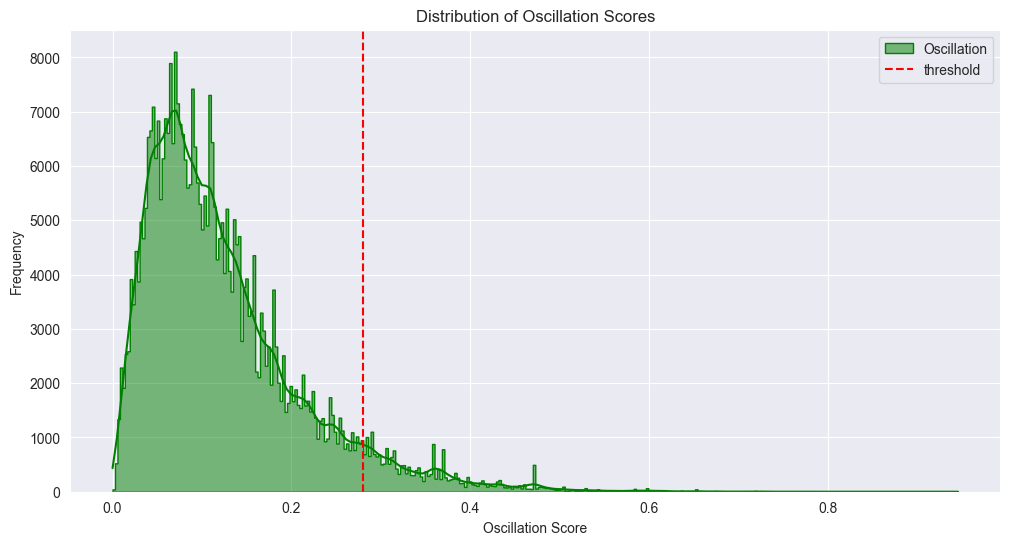

In [126]:
plt.figure(figsize=(12, 6))
sns.histplot(data=path_link_sentiment, x="oscillation", color="green", label="Oscillation", kde=True, element="step")
plt.axvline(x=threshold_oscillation, color='red', linestyle='--', label='threshold')
plt.title("Distribution of Oscillation Scores")
plt.xlabel("Oscillation Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

check which percentage of the links are above the threshold

In [71]:
path_link_sentiment[path_link_sentiment['oscillation'] > threshold_oscillation].shape[0] / path_link_sentiment.shape[0]

0.062066119835950784

Users choose %94 of the links as oscillation links, while oscillation links only account for %90 if random choose.
perfrom a random test to see if the threshold is reasonable.

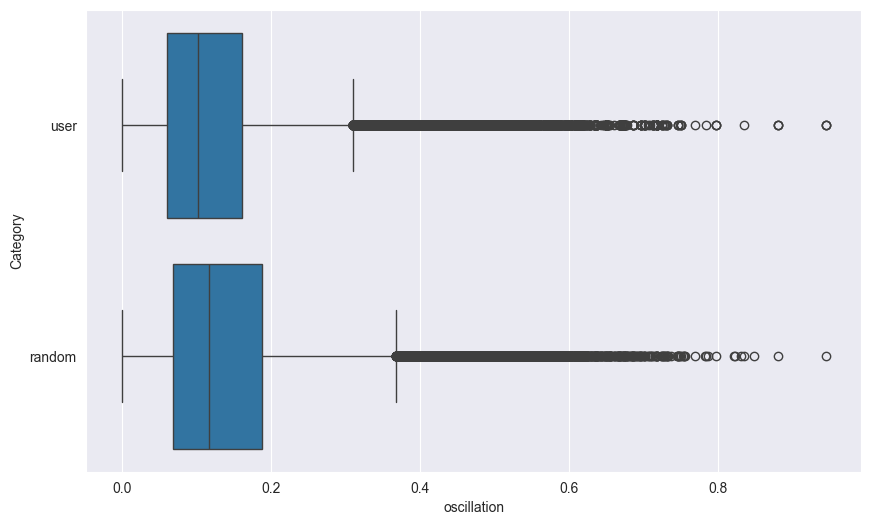

In [124]:

d1 = path_link_sentiment['oscillation']
d2 = link_sentiments['oscillation']

df_box = pd.concat([d1.rename('oscillation'), d2.rename('oscillation')], axis=0, keys=['user', 'random'], names=['Category']).reset_index()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, x='oscillation', y='Category')
plt.show()

In [147]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(link_sentiments['oscillation'],path_link_sentiment['oscillation'].dropna(), equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 55.93270338503617
p-value: 0.0


users dont tend to choose a more/less oscillated path